# Regression Open-Ended Project

-----

# Previous Notebooks

- Web Scraping
- Cleaning data
- Exploratory Data Analysis
- Feature Engineering
- Further Explatory Data Analysis

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

In [3]:
df = pickle.load(open('../data/processed/ebert_imdb_final_df.pkl', 'rb'))

We need to determine which columns to drop, since not all of them are usable as predictors.

In [4]:
df.head(2).T

,0,1
Title,Call Me by Your Name,Mudbound
IMDB_Rating,8.4,7.4
Rating_Count,4766,2666
Description,Directed by Luca Guadagnino. With Armie Hamme...,"Directed by Dee Rees. With Carey Mulligan, Ga..."
Metascore,93,86
User_Review_Count,39,22
Critic_Review_Count,107,61
Country,USA,USA
Release_Date,2017-11-24 00:00:00,2017-11-17 00:00:00
EbertStars,4,4


We already have created numeric versions of features of interest, so let's just drop all non-numeric columns

In [5]:
# drop non-numeric
df.drop(df.select_dtypes('O').columns, axis=1, inplace=True)
# drop any rows with null values
df.dropna(inplace=True)

In [6]:
# Only Ebert rated (he died in 2013)
df = df[df['Year'] < 2013]
# create binary labels indicating whether or not a movie is watchable
labels = df['EbertStars'].apply(lambda x: 1 if x >= 3.0 else 0)
# drop EbertStars and Release_Date from data
df.drop(['EbertStars', 'Release_Date'], axis=1, inplace=True)

Below we will normalize continuous variables, and that also means we need to ensure we do not normalize our binary features.

In [7]:
non_bin = [c for c in df.columns if set(df[c]) != set([0,1])]
non_bin

['IMDB_Rating',
 'Rating_Count',
 'Metascore',
 'User_Review_Count',
 'Critic_Review_Count',
 'Year',
 'Runtime',
 'UC_Ratio',
 'Description_Len',
 'Review_Len',
 'Film-Noir',
 'Game-Show',
 'Reality-TV',
 'Talk-Show',
 '',
 'Andrey Zvyagintsev',
 'Arthur Hiller',
 'Blake Edwards',
 'Bob Rafelson',
 'Chan-wook Park',
 'George Sluizer',
 'Jalil Lespert',
 'Jay Beattie',
 'Jennifer Love Hewitt',
 'Joe Swanberg',
 'John Irvin',
 'Keanu Reeves',
 'Kenneth Biller',
 'Mark Joffe',
 'Martha Coolidge',
 'Nick Castle',
 'Orson Welles',
 'Pablo Larraín',
 'Peter Landesman',
 'Peter Medak',
 'Roland Joffé',
 'Stuart Gordon',
 'Tom Holland',
 'star_weighted_rating',
 1920,
 1930,
 1940]

This is interesting: we have a column with no name, and there are several actors who don't appear in any of out movies, notably an A-list Keano Reeves. Let's drop all of the columns with no values.

In [8]:
# be sure we don't drop 'star_weighted_rating'
drop_cols = non_bin[11:-4] + non_bin[-3:]
# update non_bin
non_bin = [c for c in non_bin if c not in drop_cols]
# drop
df.drop(drop_cols, axis=1, inplace=True)

In [9]:
df.loc[:, non_bin]

,IMDB_Rating,Rating_Count,Metascore,User_Review_Count,Critic_Review_Count,Year,Runtime,UC_Ratio,Description_Len,Review_Len,Film-Noir,star_weighted_rating
47,7.7,7040.0,72.0,28.0,134.0,2010.0,105.0,0.208955,43,565,0,2.666667
96,5.0,5529.0,27.0,61.0,87.0,1990.0,111.0,0.701149,52,525,0,2.823529
142,5.5,8072.0,47.0,77.0,33.0,1998.0,120.0,2.333333,60,700,0,2.392857
150,7.7,153731.0,90.0,366.0,202.0,1980.0,152.0,1.811881,43,1289,0,2.500000
196,5.3,8677.0,36.0,34.0,25.0,1994.0,130.0,1.360000,41,871,0,2.125000
299,5.5,110047.0,34.0,638.0,387.0,1999.0,124.0,1.648579,38,740,0,2.768293
378,5.3,46566.0,43.0,335.0,211.0,2001.0,91.0,1.587678,41,866,0,2.981481
392,6.0,157865.0,49.0,645.0,208.0,2006.0,98.0,3.100962,51,657,0,2.875000
394,5.0,6689.0,45.0,52.0,94.0,1996.0,111.0,0.553191,30,825,0,2.447368
426,4.5,4106.0,34.0,47.0,76.0,1997.0,115.0,0.618421,33,584,0,2.750000


In [10]:
# Keep test set away till final model
train, test, labels_tr, labels_ts = train_test_split(df, labels, test_size=0.2)

In [11]:
# Standardize continuous variables
movie_cont_train = train.loc[:, non_bin]
movie_cont_test = test.loc[:, non_bin]
stdsc = StandardScaler()
movie_cont_sc_train = stdsc.fit_transform(movie_cont_train.values)
movie_cont_sc_test = stdsc.transform(movie_cont_test.values)

movie_cont_train = pd.DataFrame(movie_cont_sc_train, 
                                index=movie_cont_train.index, 
                                columns=movie_cont_train.columns)
movie_cont_test = pd.DataFrame(movie_cont_sc_test, 
                                index=movie_cont_test.index, 
                                columns=movie_cont_test.columns)
# combine standardized with all from original frame except non_bin
movie_sc_train = pd.concat([movie_cont_train, train.drop(non_bin, axis=1)], axis=1, join='inner')
movie_sc_test = pd.concat([movie_cont_test, test.drop(non_bin, axis=1)], axis=1, join='inner')

In [12]:
movie_sc_train = movie_sc_train.sort_index()
movie_sc_train.head()

,IMDB_Rating,Rating_Count,Metascore,User_Review_Count,Critic_Review_Count,Year,Runtime,UC_Ratio,Description_Len,Review_Len,...,Yorgos Lanthimos,Zack Snyder,Éric Rohmer,1950,1960,1970,1980,1990,2000,2010
47,1.173339,-0.547750,0.799547,-0.646918,0.009968,1.051120,-0.129573,-1.123413,0.108699,-1.045901,...,0,0,0,0,0,0,0,0,0,1
142,-1.371773,-0.540489,-0.707395,-0.512520,-0.935308,-0.550428,0.702988,0.308329,1.330426,-0.275623,...,0,0,0,0,0,0,0,1,0,0
150,1.173339,0.484323,1.884545,0.280160,0.646392,-2.952749,2.479119,-0.043108,0.108699,3.085074,...,0,0,0,0,0,0,1,0,0,0
196,-1.603147,-0.536232,-1.370449,-0.630461,-1.010181,-1.084277,1.258029,-0.347657,-0.035034,0.700063,...,0,0,0,0,0,0,0,1,0,0
299,-1.371773,0.176976,-1.491005,1.026211,2.377838,-0.416965,0.925004,-0.153167,-0.250633,-0.047392,...,0,0,0,0,0,0,0,1,0,0


In [13]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(movie_sc_train, labels_tr)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, movie_sc_train, labels_tr, cv=3, scoring="accuracy")

array([ 0.45403377,  0.5943662 ,  0.52676056])

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, movie_sc_train, labels_tr, cv=3)

In [16]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [17]:
from sklearn.metrics import confusion_matrix

C = confusion_matrix(labels_tr, y_train_pred)

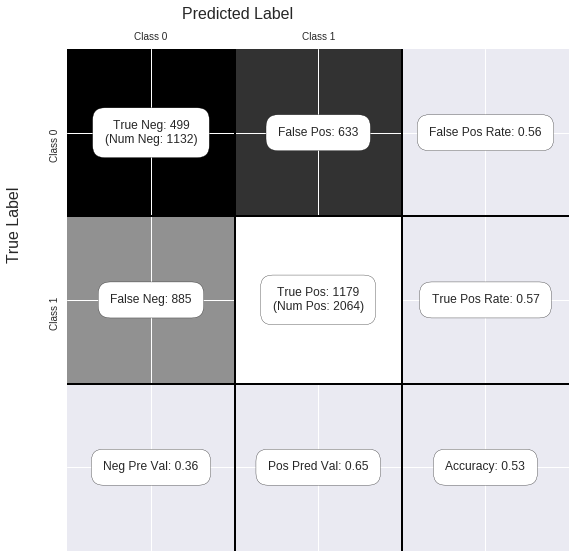

In [18]:
show_confusion_matrix(C, ['Class 0', 'Class 1'])

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(labels_tr, y_train_pred)

0.65066225165562919

In [20]:
recall_score(labels_tr, y_train_pred)

0.57122093023255816

In [21]:
from sklearn.metrics import f1_score

f1_score(labels_tr, y_train_pred)

0.60835913312693513

In [22]:
y_scores = cross_val_predict(sgd_clf, movie_sc_train, labels_tr, cv=3, method="decision_function")

In [23]:
if y_scores.ndim == 2:
    y_scores = y_scores[:, 1]

In [24]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(labels_tr, y_scores)

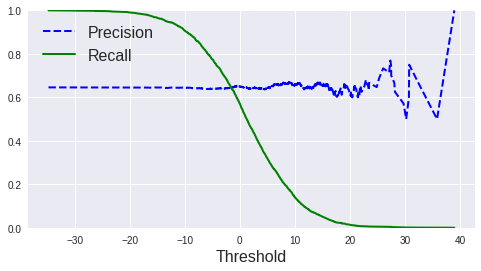

In [25]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

LinearSVM


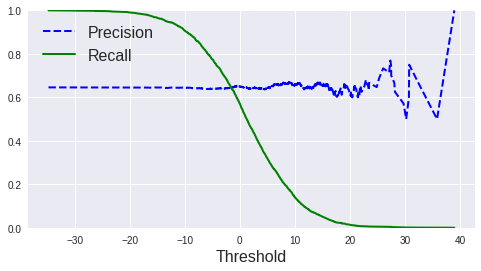

LogisticRegression


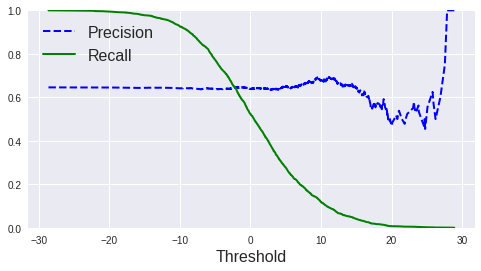

GradientBoostingClassifier


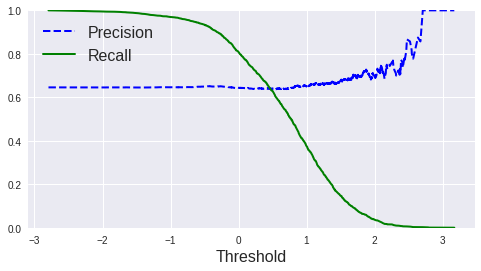

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

linear_svm_clf = SGDClassifier(loss="hinge", random_state=42)
log_reg_clf = SGDClassifier(loss="log", random_state=42)
grd_clf = GradientBoostingClassifier(n_estimators=500, random_state=42)

classifiers = [('LinearSVM', linear_svm_clf), 
               ('LogisticRegression', log_reg_clf),
               ('GradientBoostingClassifier', grd_clf)]

for name, clf in classifiers:
    y_scores = cross_val_predict(clf, movie_sc_train, labels_tr, cv=3, method="decision_function")

    if y_scores.ndim == 2:
        y_scores = y_scores[:, 1]
    
    precisions, recalls, thresholds = precision_recall_curve(labels_tr, y_scores)
    
    print(name)
    plt.figure(figsize=(8, 4))
    plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
    plt.show()

To maximize precision, recall would go close to 0. It would be a high trade-off. I would like to target at least 80% precision so that 8/10 movies I watch would be equivalent to an Ebert 3.0 or better.

In [27]:
from sklearn.model_selection import GridSearchCV

# Grid search
param_test = {'min_samples_split': range(1000, 2100, 200), 'min_samples_leaf': range(30, 71, 10)}
gs = GridSearchCV(estimator = GradientBoostingClassifier(
        learning_rate=0.1, min_samples_split=500 ,min_samples_leaf=50,
        max_depth=8, max_features='sqrt', subsample=0.8, random_state=42), 
        param_grid = param_test, scoring='precision', n_jobs=4, iid=False, cv=5)

gs.fit(movie_sc_train, labels_tr)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=50, min_samples_split=500,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=0.8, verbose=0,
              warm_start=False),
       fit_params=None, iid=False, n_jobs=4,
       param_grid={'min_samples_split': range(1000, 2100, 200), 'min_samples_leaf': range(30, 71, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

In [28]:
gs.best_params_, gs.best_score_

({'min_samples_leaf': 30, 'min_samples_split': 1200}, 0.64862876481015275)

In [29]:
from sklearn.metrics import accuracy_score

In [30]:
# Test final model
final_model = gs.best_estimator_

In [31]:
final_predictions = final_model.predict(movie_sc_test)

print("Precision", precision_score(labels_ts, final_predictions))
print("Recall", recall_score(labels_ts, final_predictions))
print("Accuracy", accuracy_score(labels_ts, final_predictions))

Precision 0.63829787234
Recall 1.0
Accuracy 0.63829787234


In [32]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy='most_frequent', random_state=0)
clf.fit(movie_sc_train, labels_tr)
clf.score(movie_sc_test, labels_ts)  

0.63829787234042556

# Conclusions, Lessons Learned and Further Research

In the end, the modeling approach before as well as a dummy classifier that simply picked the most common class. I could definitely shift the threshold in favor of precision, but recall would plummet to 0. In this example, I'd rather watch only good movies and have a few false positives (bad movies recommended), even if that means missing a bunch of good ones. However, in a realistic scenario, an extreme decision approach would not be recommended. 

It may be impossible to model Roger Ebert's interpretation of movies. Although many movies are generally accepted as true, there is a fair amount of subjectivity when it comes to critiquing movies. Most likely, I would need to add better features. Off the top of my head, using natural language processing to extract topics, keywords and sentiment could definitely hit at whether the review is positive or negative.

At the same time, I realize that many of the features may not be available at the time of movie release and some of them are available within 2 weeks or even 2 months after the theatrical release. I'd need to narrow down the evaluation metric and features that would be usable if I were to continue working on this project.